In [37]:
import os
import sys
import warnings
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,BayesianRidge,Ridge
import seaborn as sns
import statsmodels.api as sm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern,RationalQuadratic,ExpSineSquared

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, DBSCAN, Birch, OPTICS, AffinityPropagation, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler


if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Task 1: NASA Airfoil self-nosie analysis
There are 6 entities in this data set, the goal of this problem is to predict the Sound Pressure Level given the other 5 features. To evaluate the target variable as accurately as possible, we may use full of the features, or we should shrink some of them by adding regularisation term. Also the feature function $$y=f(\textbf x)+ \epsilon $$ is worth exploring in this task. I will first try linear models and then Gaussian processes regression to assess the goodness of fit of models.

## Brief data description
#### **<span >Features</span>**
- <b>frequency</b> : Frequency, in Hertz (Hz). <br>
- <b>angle</b> : Angle of attack (degrees). <br>
- <b>chord</b> : Chord length (m). <br>
- <b>velocity</b> : Free-stream velocity. <br>
- <b>thickness</b> : Suction side displacement thickness.

#### **<span> Targets </span>**
- <b>pressure</b> : Sound Pressure Level.

In [242]:
file_path = 'airfoil_self_noise.dat'
variable_names = ['frequency','angle','chord','velocity','thickness','pressure']
df = pd.read_csv(file_path,names=variable_names,header=0,delimiter='\t')
df.head()

,frequency,angle,chord,velocity,thickness,pressure
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  1502 non-null   int64  
 1   angle      1502 non-null   float64
 2   chord      1502 non-null   float64
 3   velocity   1502 non-null   float64
 4   thickness  1502 non-null   float64
 5   pressure   1502 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB


## Simple EDA(Exploratory Data Analysis)

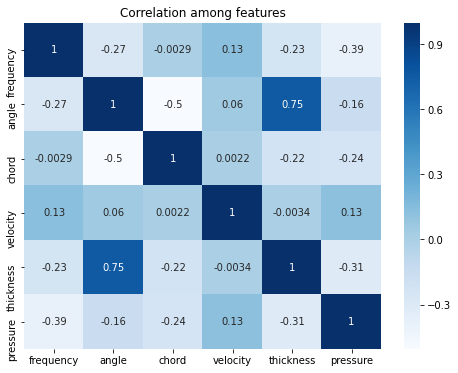

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
cor = df.corr()
sns.heatmap(df.corr(), cmap="Blues", annot=True)
plt.title("Correlation among features")
plt.savefig("correlation.png")
plt.show()

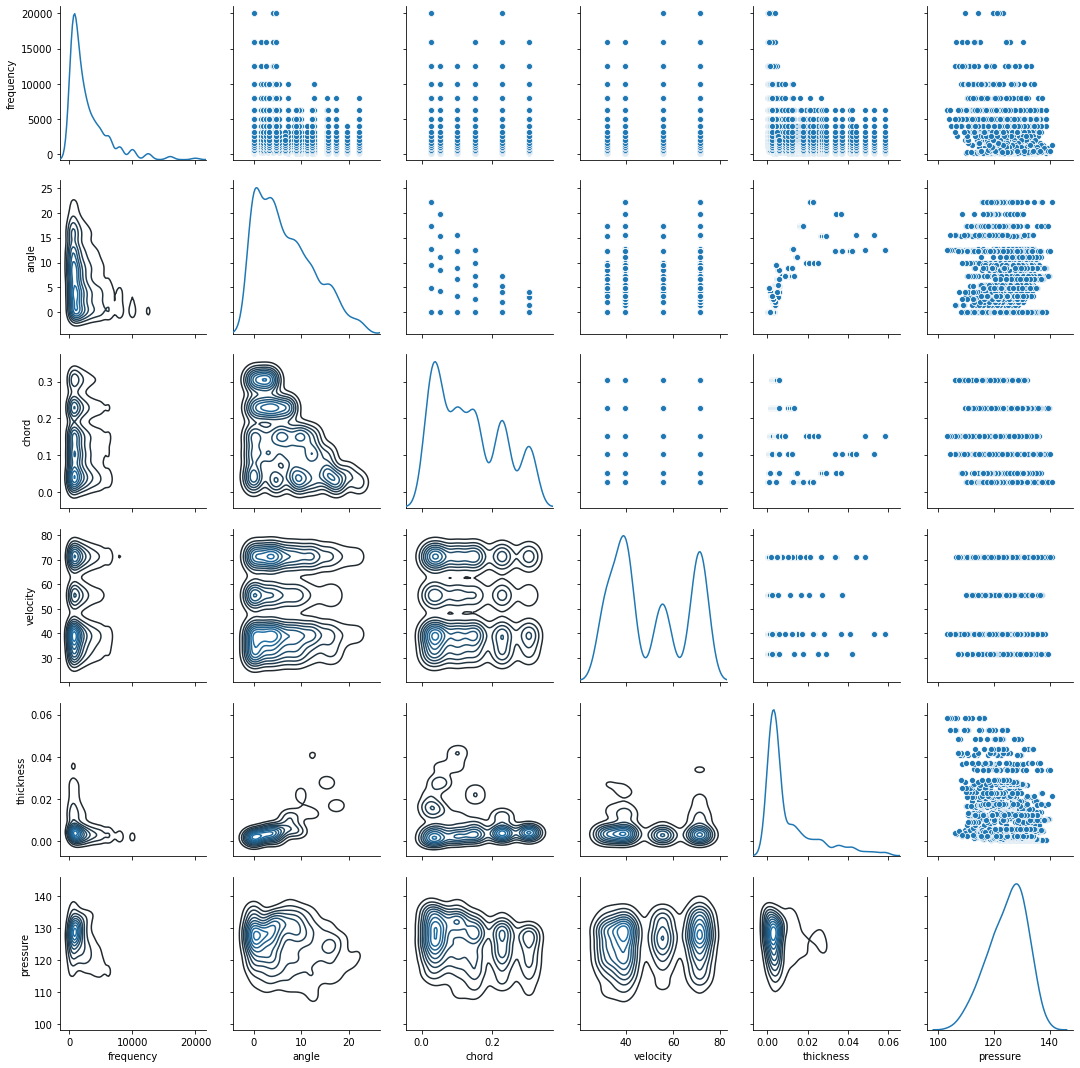

In [58]:
g = sns.PairGrid(df,diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
#g.figure.savefig("pairplot.png")
plt.savefig("pairplot.png")
plt.show()

## Prediction Models

In [381]:
features = ['frequency','angle','chord','velocity','thickness']
response = ["pressure"]
X_full, y_full = df[features], df[response]

In [382]:
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.2)

In [383]:
df_test = X_test.assign(pressure = y_test)
df_train = X.assign(pressure = y)

#### Linear Regression

In [357]:
OLS = LinearRegression(fit_intercept=True)
OLS.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0.5, 0.98, 'Training set')

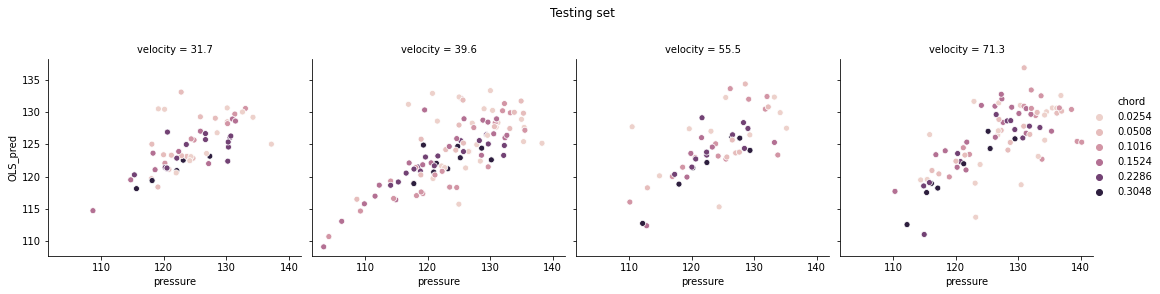

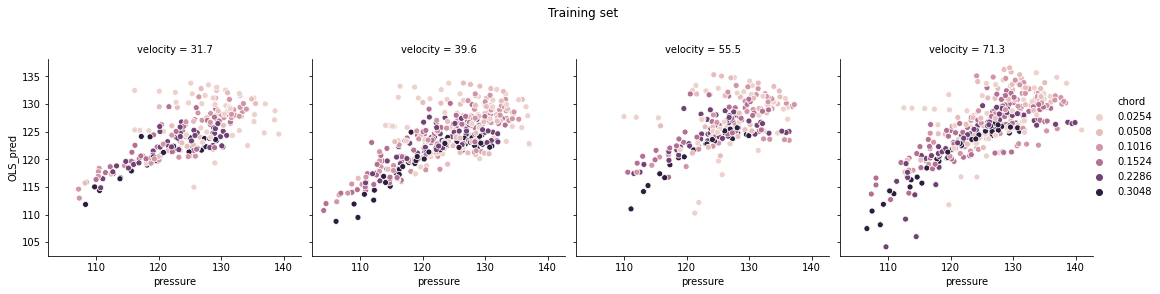

In [401]:
OLS_df_test = df_test.assign(OLS_pred=OLS.predict(X_test))
OLS_df_train = df_train.assign(OLS_pred=OLS.predict(X))

ols_test = sns.relplot(x='pressure',y='OLS_pred',col='velocity',hue='chord',data=OLS_df_test,
            kind='scatter',legend='full')
ols_test.fig.set_size_inches(16,4)
ols_test.fig.subplots_adjust(top=.8)
ols_test.fig.suptitle('Testing set')

ols_train = sns.relplot(x='pressure',y='OLS_pred',col='velocity',hue='chord',data=OLS_df_train,
            kind='scatter',legend='full')
ols_train.fig.set_size_inches(16,4)
ols_train.fig.subplots_adjust(top=.8)
ols_train.fig.suptitle('Training set')
#plt.savefig("OLS.png")

#### Bayesian Ridge Regression
This model returns target values that follow some posterior distribution, the .predict method only returns the mean of the posterior.

In [386]:
BLR = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
BLR.fit(X, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=1e-06, verbose=False)

Text(0.5, 0.98, 'Training set')

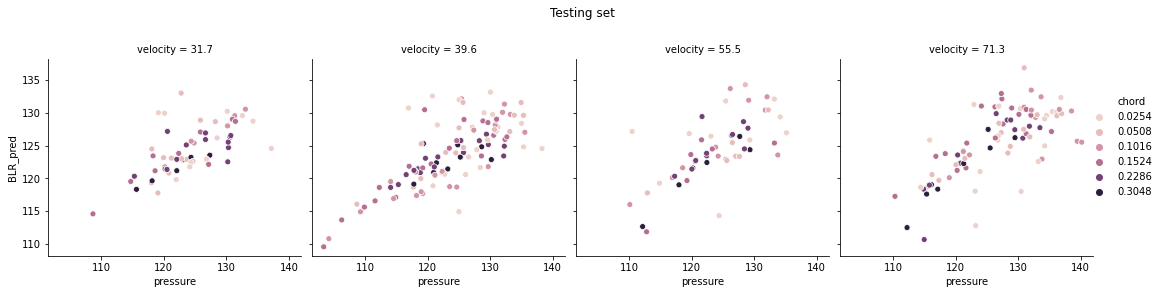

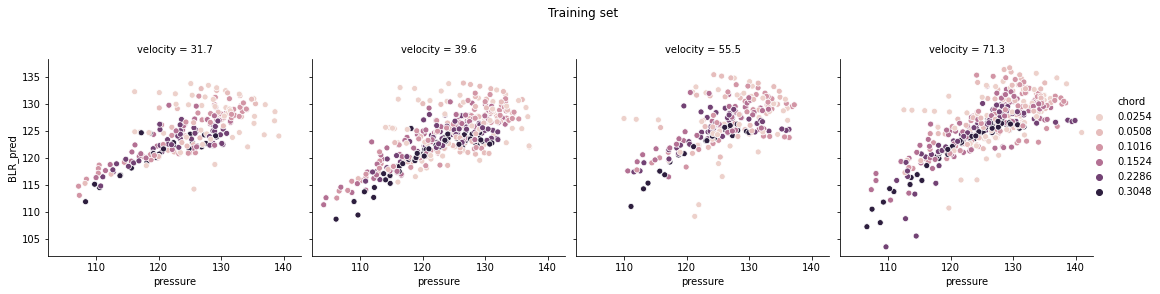

In [400]:
BLR_df_test = df_test.assign(BLR_pred=BLR.predict(X_test))
BLR_df_train = df_train.assign(BLR_pred=BLR.predict(X))

blr_test = sns.relplot(x='pressure',y='BLR_pred',col='velocity',hue='chord',data=BLR_df_test,
            kind='scatter',legend='full')
blr_test.fig.set_size_inches(16,4)
blr_test.fig.subplots_adjust(top=.8)
blr_test.fig.suptitle('Testing set')

blr_train = sns.relplot(x='pressure',y='BLR_pred',col='velocity',hue='chord',data=BLR_df_train,
            kind='scatter',legend='full')
blr_train.fig.set_size_inches(16,4)
blr_train.fig.subplots_adjust(top=.8)
blr_train.fig.suptitle('Training set')

#### Gaussian Processes Regression

In [443]:
#Matern,RationalQuadratic
GPR = GaussianProcessRegressor(kernel=RationalQuadratic())
GPR.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

Text(0.5, 0.98, 'Training set')

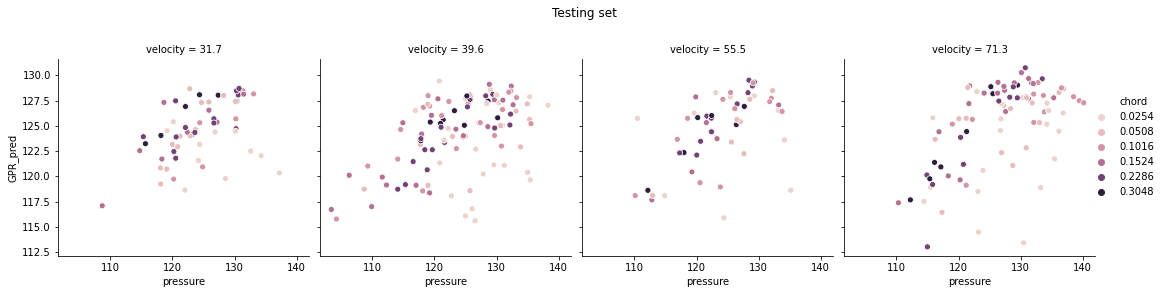

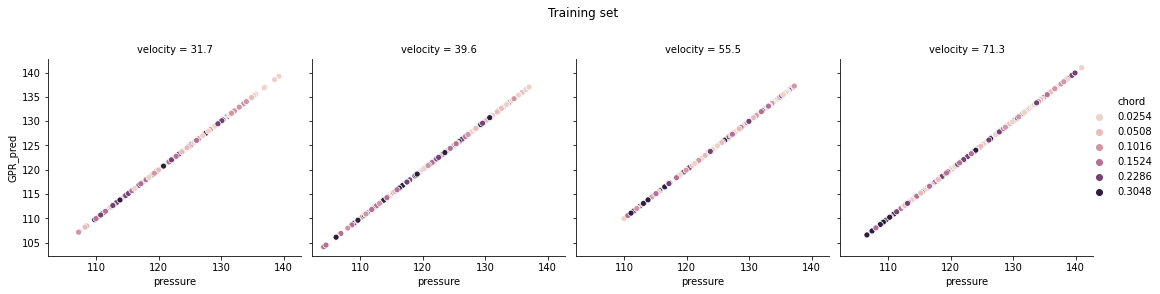

In [444]:
GPR_df_test = df_test.assign(GPR_pred=GPR.predict(X_test))
GPR_df_train = df_train.assign(GPR_pred=GPR.predict(X))

gp_test = sns.relplot(x='pressure',y='GPR_pred',col='velocity',hue='chord',data=GPR_df_test,
            kind='scatter',legend='full')
gp_test.fig.set_size_inches(16,4)
gp_test.fig.subplots_adjust(top=.8)
gp_test.fig.suptitle('Testing set')

gp_train = sns.relplot(x='pressure',y='GPR_pred',col='velocity',hue='chord',data=GPR_df_train,
            kind='scatter',legend='full')
gp_train.fig.set_size_inches(16,4)
gp_train.fig.subplots_adjust(top=.8)
gp_train.fig.suptitle('Training set')
#plt.savefig("GPR.png")

In [402]:
GPR_df = df.assign(GPR_pred=GPR.predict(X_full))
OLS_df = df.assign(OLS_pred=OLS.predict(X_full))
BLR_df = df.assign(BLR_pred=BLR.predict(X_full))

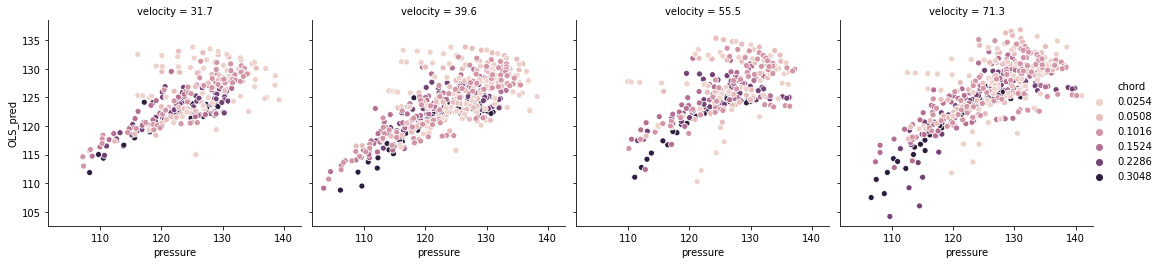

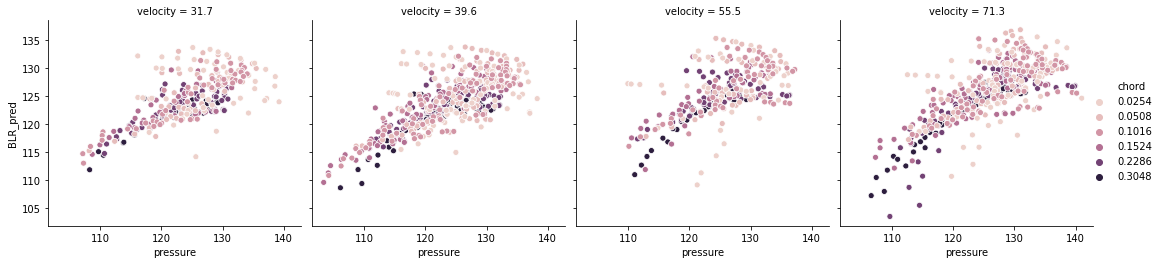

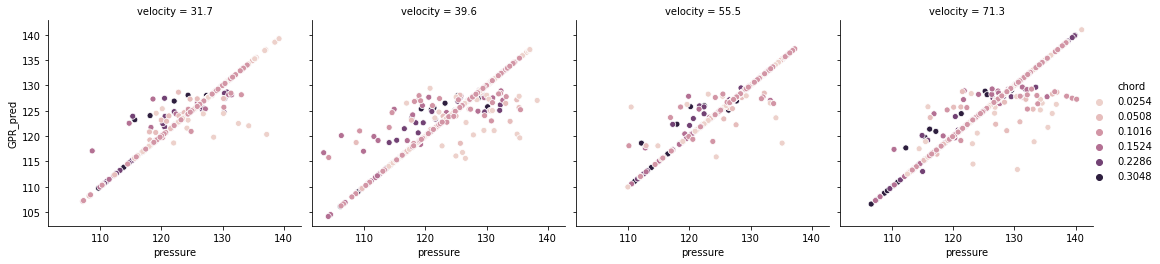

In [403]:
ols = sns.relplot(x='pressure',y='OLS_pred',col='velocity',hue='chord',data=OLS_df,
            kind='scatter',legend='full')
blr = sns.relplot(x='pressure',y='BLR_pred',col='velocity',hue='chord',data=BLR_df,
            kind='scatter',legend='full')
gp = sns.relplot(x='pressure',y='GPR_pred',col='velocity',hue='chord',data=GPR_df,
            kind='scatter',legend='full')
gp.fig.set_size_inches(16,3.5)
ols.fig.set_size_inches(16,3.5)
blr.fig.set_size_inches(16,3.5)

# Task 2: Facebook Live Sellers in Thailand

**Data cleaning**

Only useful attributes will be chosen.

In [5]:
df = pd.read_csv("Live.csv")
df = df[df.columns[3:12]].assign(status=df["status_type"])
df.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status
0,529,512,262,432,92,3,1,1,0,video
1,150,0,0,150,0,0,0,0,0,photo
2,227,236,57,204,21,1,1,0,0,video
3,111,0,0,111,0,0,0,0,0,photo
4,213,0,0,204,9,0,0,0,0,photo


Notice that the num_reactions=num_likes+num_loves+num_wows+num_hahas+num_sads+num_angrys. We can then divide these reactions into two categories:

Positive = num_likes+num_loves+num_wows+num_hahas

Negative = num_sads+num_angrys

In [6]:
df["positive"] = df["num_likes"]+df["num_loves"]+df["num_wows"]+df["num_hahas"]
df["negative"] = df["num_sads"]+df["num_angrys"]
df = df[df["num_reactions"] == df["positive"]+df["negative"]][["num_comments", "num_shares", "positive", "negative", "status"]]

In [7]:
df.head()

,num_comments,num_shares,positive,negative,status
0,512,262,528,1,video
1,0,0,150,0,photo
2,236,57,227,0,video
3,0,0,111,0,photo
4,0,0,213,0,photo


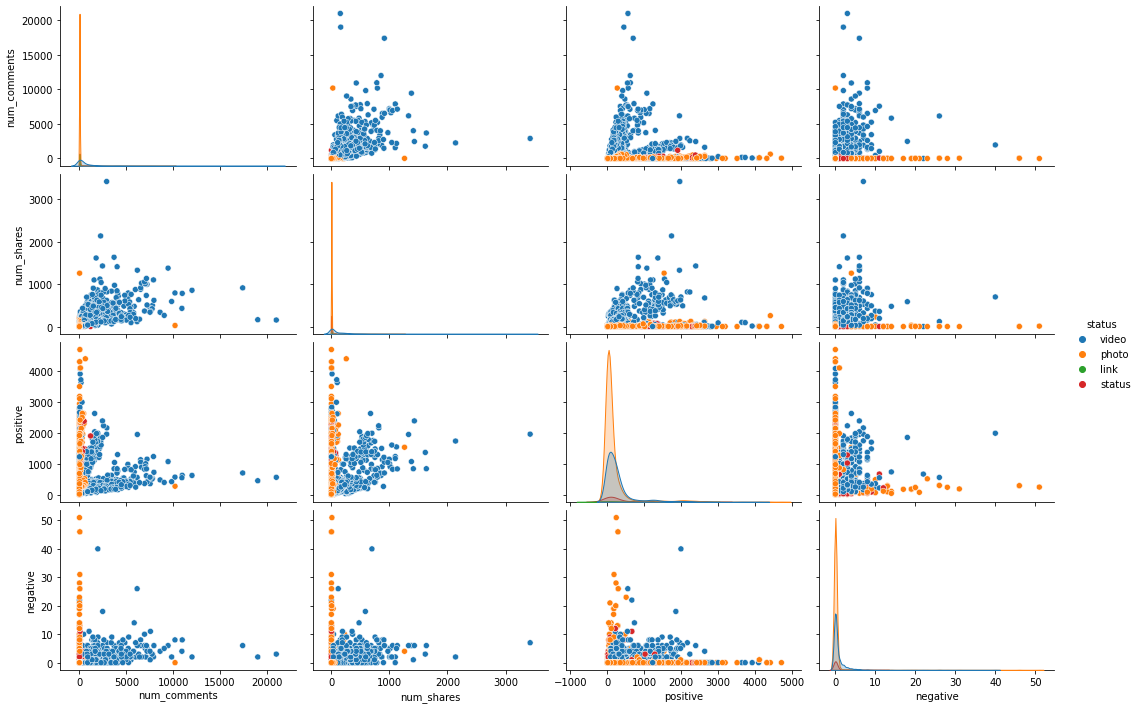

In [396]:
sns.pairplot(df, hue="status", aspect=1.5)
plt.savefig("fb_pair.png")
plt.show()

From the above plot status has no direct relation to segmenting reactions, we can drop it and move on with other features.

In [8]:
df = df.drop(["status"], axis=1)
df

,num_comments,num_shares,positive,negative
0,512,262,528,1
1,0,0,150,0
2,236,57,227,0
3,0,0,111,0
4,0,0,213,0
...,...,...,...,...
7045,0,0,89,0
7046,0,0,16,0
7047,0,0,2,0
7048,12,22,351,0


### PCA Analysis: Dimensionality reduction
Because the original data has 9 features, I will first perform dimensionality reduction technique by PCA(Principal Component Analysis) to capture the largest amount of variance of the data, it is also more feasible for visulisation. 

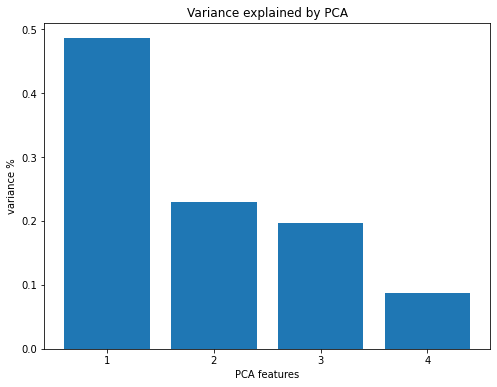

In [16]:
pca = PCA(n_components=4)
df_std = StandardScaler().fit_transform(df) #standardise data before performing PCA
principalComponents = pca.fit_transform(df_std)
# Plot the explained variances
features = range(1, pca.n_components_+1)
plt.figure(figsize = (8,6))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.title("Variance explained by PCA")
plt.savefig("PCA_num.png")
plt.show()

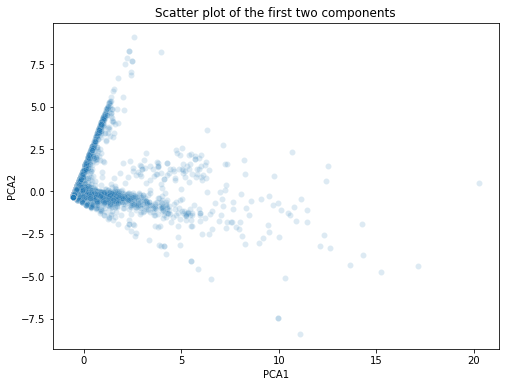

In [17]:
PCA_components = pd.DataFrame(principalComponents)[[0,1]]
PCA_components.columns=["PCA1", "PCA2"]
plt.figure(figsize = (8,6))
sns.scatterplot(x="PCA1", y="PCA2", data=PCA_components, alpha=.15).set(title="Scatter plot of the first two components")
plt.savefig("PCA_plot")
plt.show()

## Clustering Analysis

In [22]:
def visua_clusters(data, model, save=False, figname=None):
    predictions = model.fit_predict(data)  
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(data)
    df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
    df_pca['Clusters'] = predictions
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette="Set2",alpha=0.8)
    if save:
        plt.savefig(figname+".png")
    plt.title('Clusters after PCA')

### Kmeans


**Elbow method**

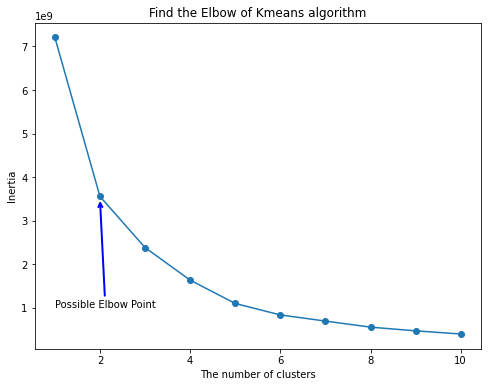

In [404]:
clus = []
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(df)
    clus.append(km.inertia_)
plt.figure(figsize = (8,6))
plt.plot(range(1, 11),clus, "o-")
plt.ylabel("Inertia")
plt.xlabel("The number of clusters")
plt.annotate("Possible Elbow Point", xy=(2,3500000000), xytext=(1, 1000000000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
plt.title("Find the Elbow of Kmeans algorithm")
plt.savefig("Elbow.png")
plt.show()

**Silhouette method**

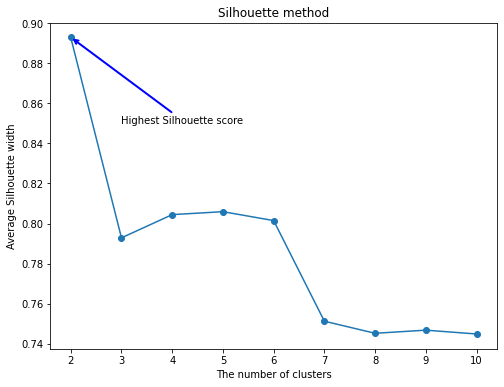

In [408]:
silhouettes = []
for i in range(2, 11):
    km = KMeans(n_clusters=i).fit(df)
    clus_labels = km.fit_predict(df)
    silhouette = silhouette_score(df, clus_labels)
    silhouettes.append(silhouette)
plt.figure(figsize = (8,6))
plt.plot(range(2, 11),silhouettes, "o-")
plt.ylabel("Average Silhouette width")
plt.xlabel("The number of clusters")
plt.annotate("Highest Silhouette score", xy=(2,0.893), xytext=(3, 0.85), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
plt.title("Silhouette method")
plt.savefig("Silhouette.png")
plt.show()

**Visualisation of clusters**

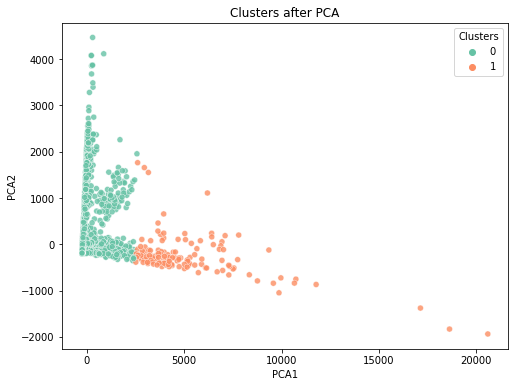

In [416]:
kmeans = KMeans(n_clusters=2)
dd = df.copy()
visua_clusters(dd,kmeans)

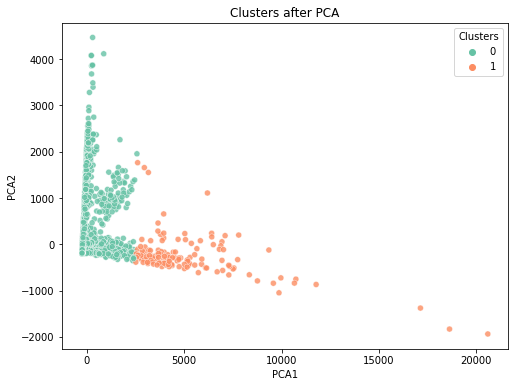

In [420]:
kmeans = KMeans(n_clusters=2)
dd = df.copy()
visua_clusters(dd,kmeans, True, "Kmeans")

### GMMs

**Cluster number selection**

In [18]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

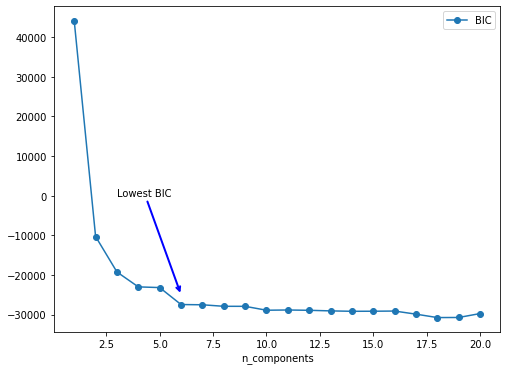

In [35]:
plt.figure(figsize = (8,6))
plt.plot(n_components, [m.bic(X) for m in models], "o-",label='BIC')
plt.annotate("Lowest BIC", xy=(6,-25000), xytext=(3, 0), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
plt.legend(loc='best')
plt.savefig("GMM_num.png")
plt.xlabel('n_components');

**Visualisation**

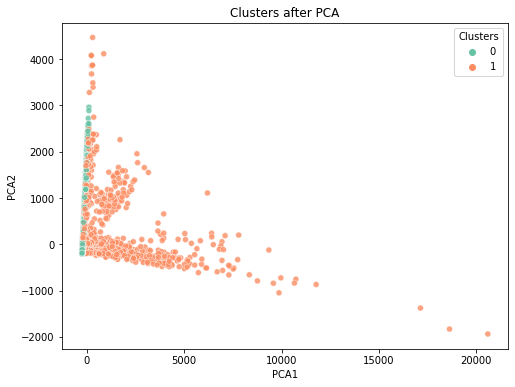

In [36]:
gmm = GaussianMixture(n_components=2, covariance_type="full")
dd = df.copy()
visua_clusters(dd, gmm, True, "GMM_2")

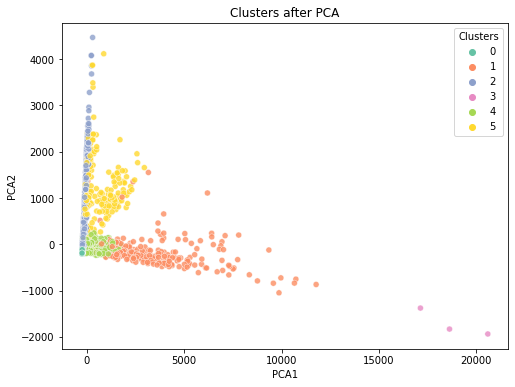

In [23]:
gmm = GaussianMixture(n_components=6, covariance_type="full")
dd = df.copy()
visua_clusters(dd, gmm, True, "GMM")

**Birch**

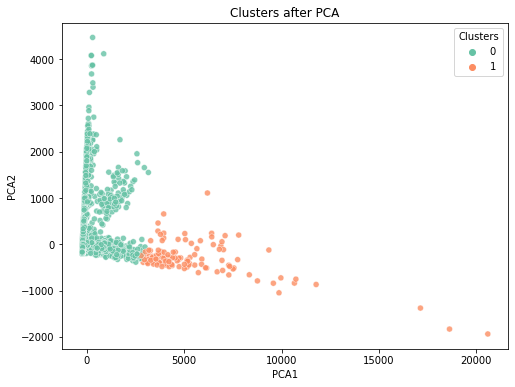

In [34]:
dd = df.sample(frac = 1)
model = Birch(threshold=0.1, n_clusters=2)
visua_clusters(dd,model,True, "Birch")